1. Load Bioarxiv Load Covid data 
2. Inner Merge to get Bio-Covid df
3. Split to paragraphs (to find topic per paragraph)
4. Prepare to-remove words: numbers, standard covid words, class words
5. Prepare Stopwords
6. Remove certain punctuation and stopwords
7. Remove emails and newline characters
8. Tokenize words and Clean-up/normalize text
9. Create Bigram and Trigram Models
10. Make Bigrams and Lemmatize
11. Create the Dictionary and Corpus needed for Topic Modeling
12. Building the Topic Model
13. View the topics in LDA model
14. Compute Model Perplexity and Coherence Score
15. Visualize the topics-keywords
16. Build a pipeline for GridSearch
17. How to find the optimal number of topics for LDA?
18. Finding the dominant topic in each paragraph
19. Find the most representative paragraph/documnet for each topic
20. Get the top 10 keywords each topic
21. Topic distribution across documents

# Libraries

In [1]:
# Miscellaneous
from collections import defaultdict
import time
import warnings

warnings.filterwarnings("ignore",category=Warning)

# Arrays & Dataframes
import numpy as np
import pandas as pd

pd.set_option('display.max_rows',1000)

# Utilities
from vasilis.utilities.constants import *
from vasilis.utilities.functions import *
from vasilis.utilities.ldamodel import LDAModel

# Gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases

# Sklearn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

# # Enable logging for gensim - optional
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


# Load Covid-Metadata and Raw Bioarxiv

In [2]:
covid_sha_ids = pd.read_csv('../data/vasilis/covid_metadata.csv', usecols=['sha'])\
                  .dropna(subset=['sha'])\
                  .loc[:,'sha'].values 

In [3]:
BIO_PATH = '../data/processed/bioarxiv.csv'
df = load_paper_data(file_path=BIO_PATH, 
                     filter_sha_ids=covid_sha_ids, 
                     remove_phrases=COMMON_PHRASES_REGEX, 
                     remove_tokens=COMMON_WORDS)

Fraction of selected papers: 857/1342


# Text Data

In [4]:
text_data = df['clean_text'].values.tolist()

In [5]:
# Add bigrams to text data
bigram_model = Phrases(text_data, min_count=3, threshold=50) # higher threshold fewer phrases.
text_data = [bigram_model[doc] for doc in text_data]

# Train LDA

In [6]:
NUM_DOCS = len(text_data)

In [7]:
# Initialize model
lda = LDAModel(text_data)

In [8]:
# Choose parameters
grid_parameters = {
    'num_topics': [5,7,9],
    'passes': [10],
    'random_state': [100],
    'chunksize': [25],
    'alpha': ['auto'],
    'per_word_topics': [True],
    'update_every': [5]
}

In [9]:
start_time = time.time()

gs_models = lda.grid_search(grid_parameters, text_data, lda_class='single')

print("Training lasted: {} sec".format(round(time.time() - start_time),3))

100%|██████████| 3/3 [01:03<00:00, 21.18s/it]

Training lasted: 64 sec


# Evaluate Model

In [10]:
data = defaultdict(list)
for model, d in gs_models.items():
    data['model'].append(model)
    data['coherence_score'].append(d['coherence_score'])
    for param_name, value in d['parameters'].items():
        data[param_name].append(value)
    
        

df_gs = pd.DataFrame.from_dict(data)\
          .set_index('model')\
          .sort_values(by='coherence_score', ascending=False)

df_gs

,coherence_score,alpha,chunksize,num_topics,passes,per_word_topics,random_state,update_every
model,,,,,,,,
model_0,0.494021,auto,25,5,10,True,100,5
model_2,0.491781,auto,25,9,10,True,100,5
model_1,0.467691,auto,25,7,10,True,100,5


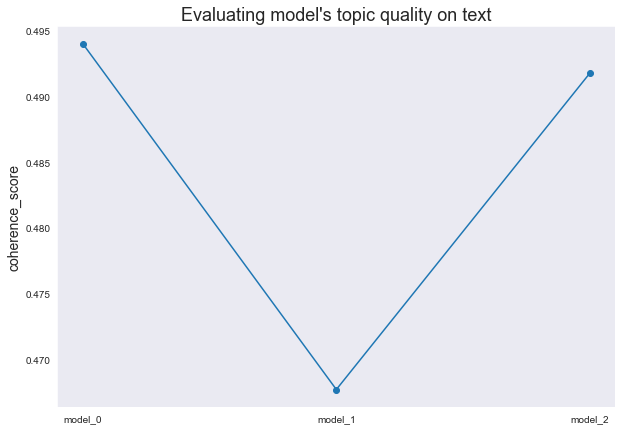

In [11]:
plt.figure(figsize=(10,7));
plt.plot(data['model'], data['coherence_score'], '-o');
plt.ylabel('coherence_score', size=14); 
plt.title("Evaluating model's topic quality on text", size=18);

# Best model

In [12]:
lda.create_topics_keywords()

topic_no,0,1,2,3,4
top_keywords,,,,,
0,outbreak,sequence,protein,patient,epidemic
1,infection,sample,cell,disease,estimate
2,country,genome,sequence,clinical,time
3,contact,rna,bind,severe,day
4,may,read,human,test,report
5,estimate,specie,sarscov,include,infect
6,individual,method,gene,group,infection
7,transmission,detection,show,infection,confirm
8,measure,detect,structure,find,city


In [13]:
print('Best Coherence Score: ', lda.coherence_score)

Best Coherence Score:  0.4940209560812905


# Evaluate model accuracy on Metadata

In [14]:
# create test corpus for metadata
meta_data = df['clean_meta'].values.tolist()
meta_corpus = lda.create_corpus(meta_data)

# predict topics
meta_preds = lda.predict_topic(meta_corpus)
text_preds = lda.predict_topic(lda.corpus)

In [15]:
f1_score(text_preds, meta_preds, average='macro')

0.8174954212520648

In [16]:
cf_matrix = confusion_matrix(text_preds, meta_preds)

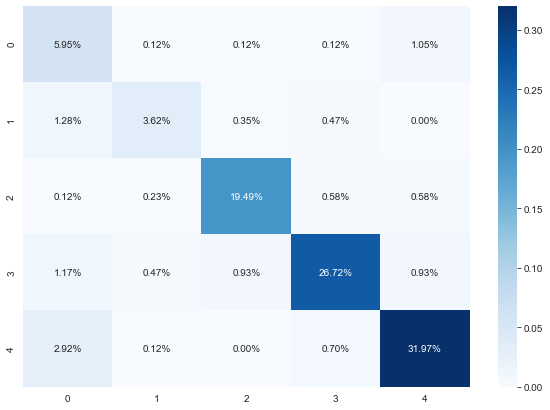

In [17]:
plt.figure(figsize=(10,7))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
             fmt='.2%', cmap='Blues');


In [18]:
gs_preds = {}
for model_no, d in gs_models.items():
    lda_model = d['lda_model']
    
    meta_preds = []
    for doc in lda_model[meta_corpus]:
        dominant_topic,_ = max(doc[0], key=lambda x: x[1])
        meta_preds.append(dominant_topic)
       
    text_preds = []
    for doc in lda_model[lda.corpus]:
        dominant_topic,_ = max(doc[0], key=lambda x: x[1])
        text_preds.append(dominant_topic)
        
    gs_preds[model_no] = f1_score(text_preds, meta_preds, average='macro')

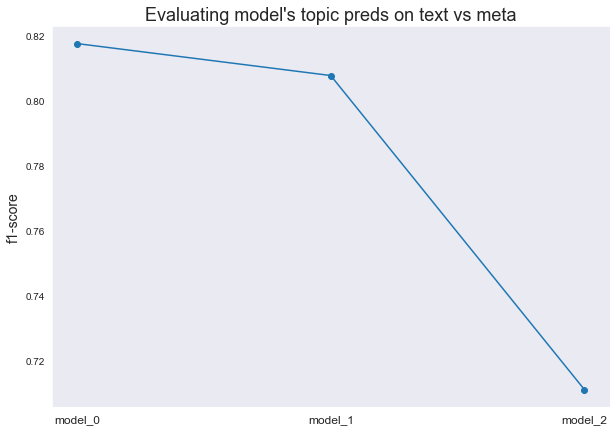

In [19]:
plt.figure(figsize=(10,7));
plt.plot(list(gs_preds.keys()), list(gs_preds.values()), '-o');
plt.xticks(size=12); plt.ylabel('f1-score', size=14); 
plt.title("Evaluating model's topic preds on text vs meta", size=18);

# Visualize Model

In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda.model, lda.corpus, lda.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.130852 -0.053527       1        1  35.867004
3      0.088525  0.158944       2        1  22.668411
2     -0.113493  0.024878       3        1  21.913275
0      0.081950 -0.106443       4        1  13.413349
1     -0.187834 -0.023852       5        1   6.137957, topic_info=                          Term         Freq        Total Category  logprob  \
315                    patient  5146.000000  5146.000000  Default  30.0000   
420                   sequence  1664.000000  1664.000000  Default  29.0000   
356                    protein  1634.000000  1634.000000  Default  28.0000   
405                     sample  1212.000000  1212.000000  Default  27.0000   
71                        cell  2018.000000  2018.000000  Default  26.0000   
827                     genome   791.000000   791.000000  Default  25.0000   
566                   epidemic  2352.000000  2352.000000  Default  24.0000   
400                        rna   727.000000   727.000000  Default  23.0000   
568                   estimate  2285.000000  2285.000000  Default  22.0000   
636                   outbreak  2021.000000  2021.000000  Default  21.0000   
528                       city  1310.000000  1310.000000  Default  20.0000   
1900                      bind   746.000000   746.000000  Default  19.0000   
424                     severe  1046.000000  1046.000000  Default  18.0000   
193                       gene   796.000000   796.000000  Default  17.0000   
81                    clinical  1034.000000  1034.000000  Default  16.0000   
542                    country  1460.000000  1460.000000  Default  15.0000   
659                       read   326.000000   326.000000  Default  14.0000   
408                    sarscov   720.000000   720.000000  Default  13.0000   
706               transmission  1521.000000  1521.000000  Default  12.0000   
221                 individual  1605.000000  1605.000000  Default  11.0000   
785                  detection   547.000000   547.000000  Default  10.0000   
1640                      host   551.000000   551.000000  Default   9.0000   
2650                    specie   272.000000   272.000000  Default   8.0000   
444                  structure   678.000000   678.000000  Default   7.0000   
213                      human  1173.000000  1173.000000  Default   6.0000   
458                    symptom  1094.000000  1094.000000  Default   5.0000   
1036                      test  1641.000000  1641.000000  Default   4.0000   
126                     detect   626.000000   626.000000  Default   3.0000   
6645                   epitope   387.000000   387.000000  Default   2.0000   
4439                    policy   411.000000   411.000000  Default   1.0000   
1226           serial_interval   199.119629   199.898438   Topic1  -6.8204   
522         basic_reproduction   220.322433   221.321884   Topic1  -6.7192   
3090                  lockdown   249.029526   250.366074   Topic1  -6.5967   
3155        travel_restriction   105.526909   106.343285   Topic1  -7.4553   
2006                  forecast   185.618820   187.093582   Topic1  -6.8906   
3193               destination    87.412529    88.165291   Topic1  -7.6436   
2715                 passenger    97.979340    98.832512   Topic1  -7.5295   
1233                       sir    84.847839    85.612854   Topic1  -7.6734   
1143               growth_rate   124.870537   125.999695   Topic1  -7.2870   
607                        lag    79.109131    79.890953   Topic1  -7.7434   
557                double_time   100.986633   102.039268   Topic1  -7.4993   
11278               turn_point    70.870857    71.619568   Topic1  -7.8534   
4940            transportation    71.538055    72.301941   Topic1  -7.8440   
2730                  traveler    70.493752    71.270943   Topic1  -7.8587   
10062           infectiousness    65.667831    66.435143   Topic1  -7

# Top Topic Per Doc

In [21]:
df_top_topic_per_doc = lda.create_top_topic_per_doc(lda.corpus)

In [22]:
df_top_topic_per_doc.head(10)

,dominant_topic,topic_probability,topic_keywords
corpus_id,,,
0,3,0.9515,"patient, disease, clinical, severe, test, incl..."
1,2,0.7261,"protein, cell, sequence, bind, human, sarscov,..."
2,4,0.7680,"epidemic, estimate, time, day, report, infect,..."
3,3,0.6446,"patient, disease, clinical, severe, test, incl..."
4,4,0.5890,"epidemic, estimate, time, day, report, infect,..."
5,3,0.9996,"patient, disease, clinical, severe, test, incl..."
6,0,0.4315,"outbreak, infection, country, contact, may, es..."
7,2,0.6360,"protein, cell, sequence, bind, human, sarscov,..."
8,3,0.9995,"patient, disease, clinical, severe, test, incl..."


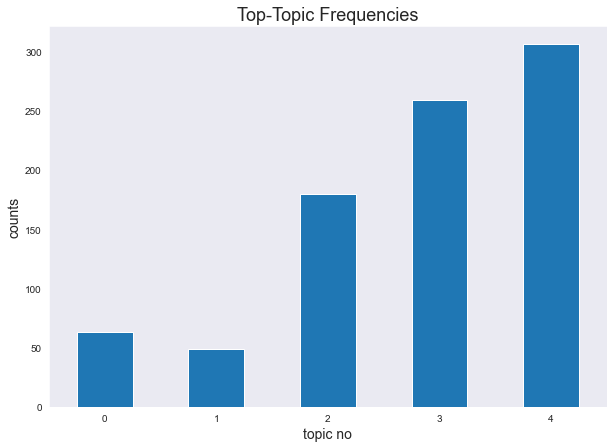

In [23]:
df_top_topic_per_doc.dominant_topic.value_counts().sort_index().plot(kind='bar', figsize=(10,7));
plt.xlabel('topic no', size=14); plt.ylabel('counts', size=14);
plt.title("Top-Topic Frequencies", size=18);
plt.xticks(rotation=0);

# Find the most representative document for each topic

In [24]:
df_rep = df_top_topic_per_doc.groupby('dominant_topic')[['topic_probability', 'topic_keywords']]\
                .apply(lambda grp: grp.sort_values(['topic_probability'], ascending=[0]).head(1))

In [25]:
df_rep

,,topic_probability,topic_keywords
dominant_topic,corpus_id,,
0,290,0.9999,"outbreak, infection, country, contact, may, es..."
1,480,0.9554,"sequence, sample, genome, rna, read, specie, m..."
2,710,0.9999,"protein, cell, sequence, bind, human, sarscov,..."
3,184,0.9997,"patient, disease, clinical, severe, test, incl..."
4,737,0.9999,"epidemic, estimate, time, day, report, infect,..."


In [26]:
topic_to_doc_rep_id = {}
for topic_no, corpus_id in df_rep.index:
    rep = df.loc[corpus_id, 'meta']
    topic_to_doc_rep_id[topic_no] = df.loc[corpus_id, 'paper_id']
    print(f"\nTopic {topic_no}\n" + "-"*10 + f"\n{rep}\n")
    


Topic 0
----------
Financing Vaccines for Global Health Security 

Recent outbreaks of infectious pathogens such as Zika, Ebola, and COVID-19 have underscored the need for the dependable availability of vaccines against emerging infectious diseases (EIDs). The cost and risk of R&D programs and uniquely unpredictable demand for EID vaccines have discouraged vaccine developers, and government and nonprofit agencies have been unable to provide timely or sufficient incentives for their development and sustained supply. We analyze the economic returns of a portfolio of EID vaccine assets, and find that under realistic financing assumptions, the expected returns are significantly negative, implying that the private sector is unlikely to address this need without public-sector intervention. We have sized the financing deficit for this portfolio and propose several potential solutions, including price increases, enhanced public-private partnerships, and subscription models through which indiv

# Save Results

In [27]:
DATA_DIR = '../data/vasilis/lda/'
lda.model.save(DATA_DIR + 'lda_model')

In [28]:
import pickle

with open(DATA_DIR + 'lda.pickle', 'wb') as handle:
    pickle.dump(lda, handle, protocol=pickle.HIGHEST_PROTOCOL)

